In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf #magical gradient computation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.corpus import stopwords

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os



# Any results you write to the current directory are saved as output.

In [2]:
data = pd.read_csv('fake_or_real_news.csv')
data = data.sample(frac = 1)
data.head()
labels = ["FAKE", "REAL"]
data['label'] = data['label'].apply(labels.index)


In [3]:
data['title_length'] = [len(title) for title in data['title']]
data.head()

,Unnamed: 0,title,text,label,title_length
5020,6199,AMERICAN EVIL,Share This: By Joe Giambrone What if everythin...,0,13
1154,4016,Acting out of weakness? Why Obama's dangerousl...,"In last Friday’s press conference, President O...",1,87
4675,10422,Bernie Sanders: The Democratic primary gave me...,Print \nSen. Bernie Sanders laid out the ways ...,0,101
1214,590,Matt Bevin is the next governor of Kentucky. H...,"Matt Bevin, the Republican nominee in the Kent...",1,77
3051,196,Congress inches closer to cliff,Notable names include Ray Washburne (Commerce)...,1,31


In [4]:
len(data)/2

3167.5

In [5]:
data['text_length'] = [len(text) for text in data['text']]
data.head()

,Unnamed: 0,title,text,label,title_length,text_length
5020,6199,AMERICAN EVIL,Share This: By Joe Giambrone What if everythin...,0,13,8618
1154,4016,Acting out of weakness? Why Obama's dangerousl...,"In last Friday’s press conference, President O...",1,87,3720
4675,10422,Bernie Sanders: The Democratic primary gave me...,Print \nSen. Bernie Sanders laid out the ways ...,0,101,1148
1214,590,Matt Bevin is the next governor of Kentucky. H...,"Matt Bevin, the Republican nominee in the Kent...",1,77,2666
3051,196,Congress inches closer to cliff,Notable names include Ray Washburne (Commerce)...,1,31,134


In [6]:
data['title_length'].describe()

count    6335.000000
mean       65.277664
std        23.733657
min         1.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: title_length, dtype: float64

In [7]:
data['text_length'].describe()

count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: text_length, dtype: float64

In [8]:
real_title = ' '.join(data[data['label'] == 1]['title'])
fake_title = ' '.join(data[data['label'] == 0]['title'])
fake_title_words = [word for word in nltk.tokenize.word_tokenize(fake_title) if word not in stopwords.words('english') and len(word) > 3]
real_title_words = [word for word in nltk.tokenize.word_tokenize(real_title) if word not in stopwords.words('english') and len(word) > 3]

#real_text = ' '.join(data[data['label'] == "REAL"]['text'])
#fake_text = ' '.join(data[data['label'] == "FAKE"]['text'])
#fake_text_words = [word for word in nltk.tokenize.word_tokenize(fake_text) if word not in stopwords.words('english') and len(word) > 3]
#real_text_words = [word for word in nltk.tokenize.word_tokenize(real_text) if word not in stopwords.words('english') and len(word) > 3]


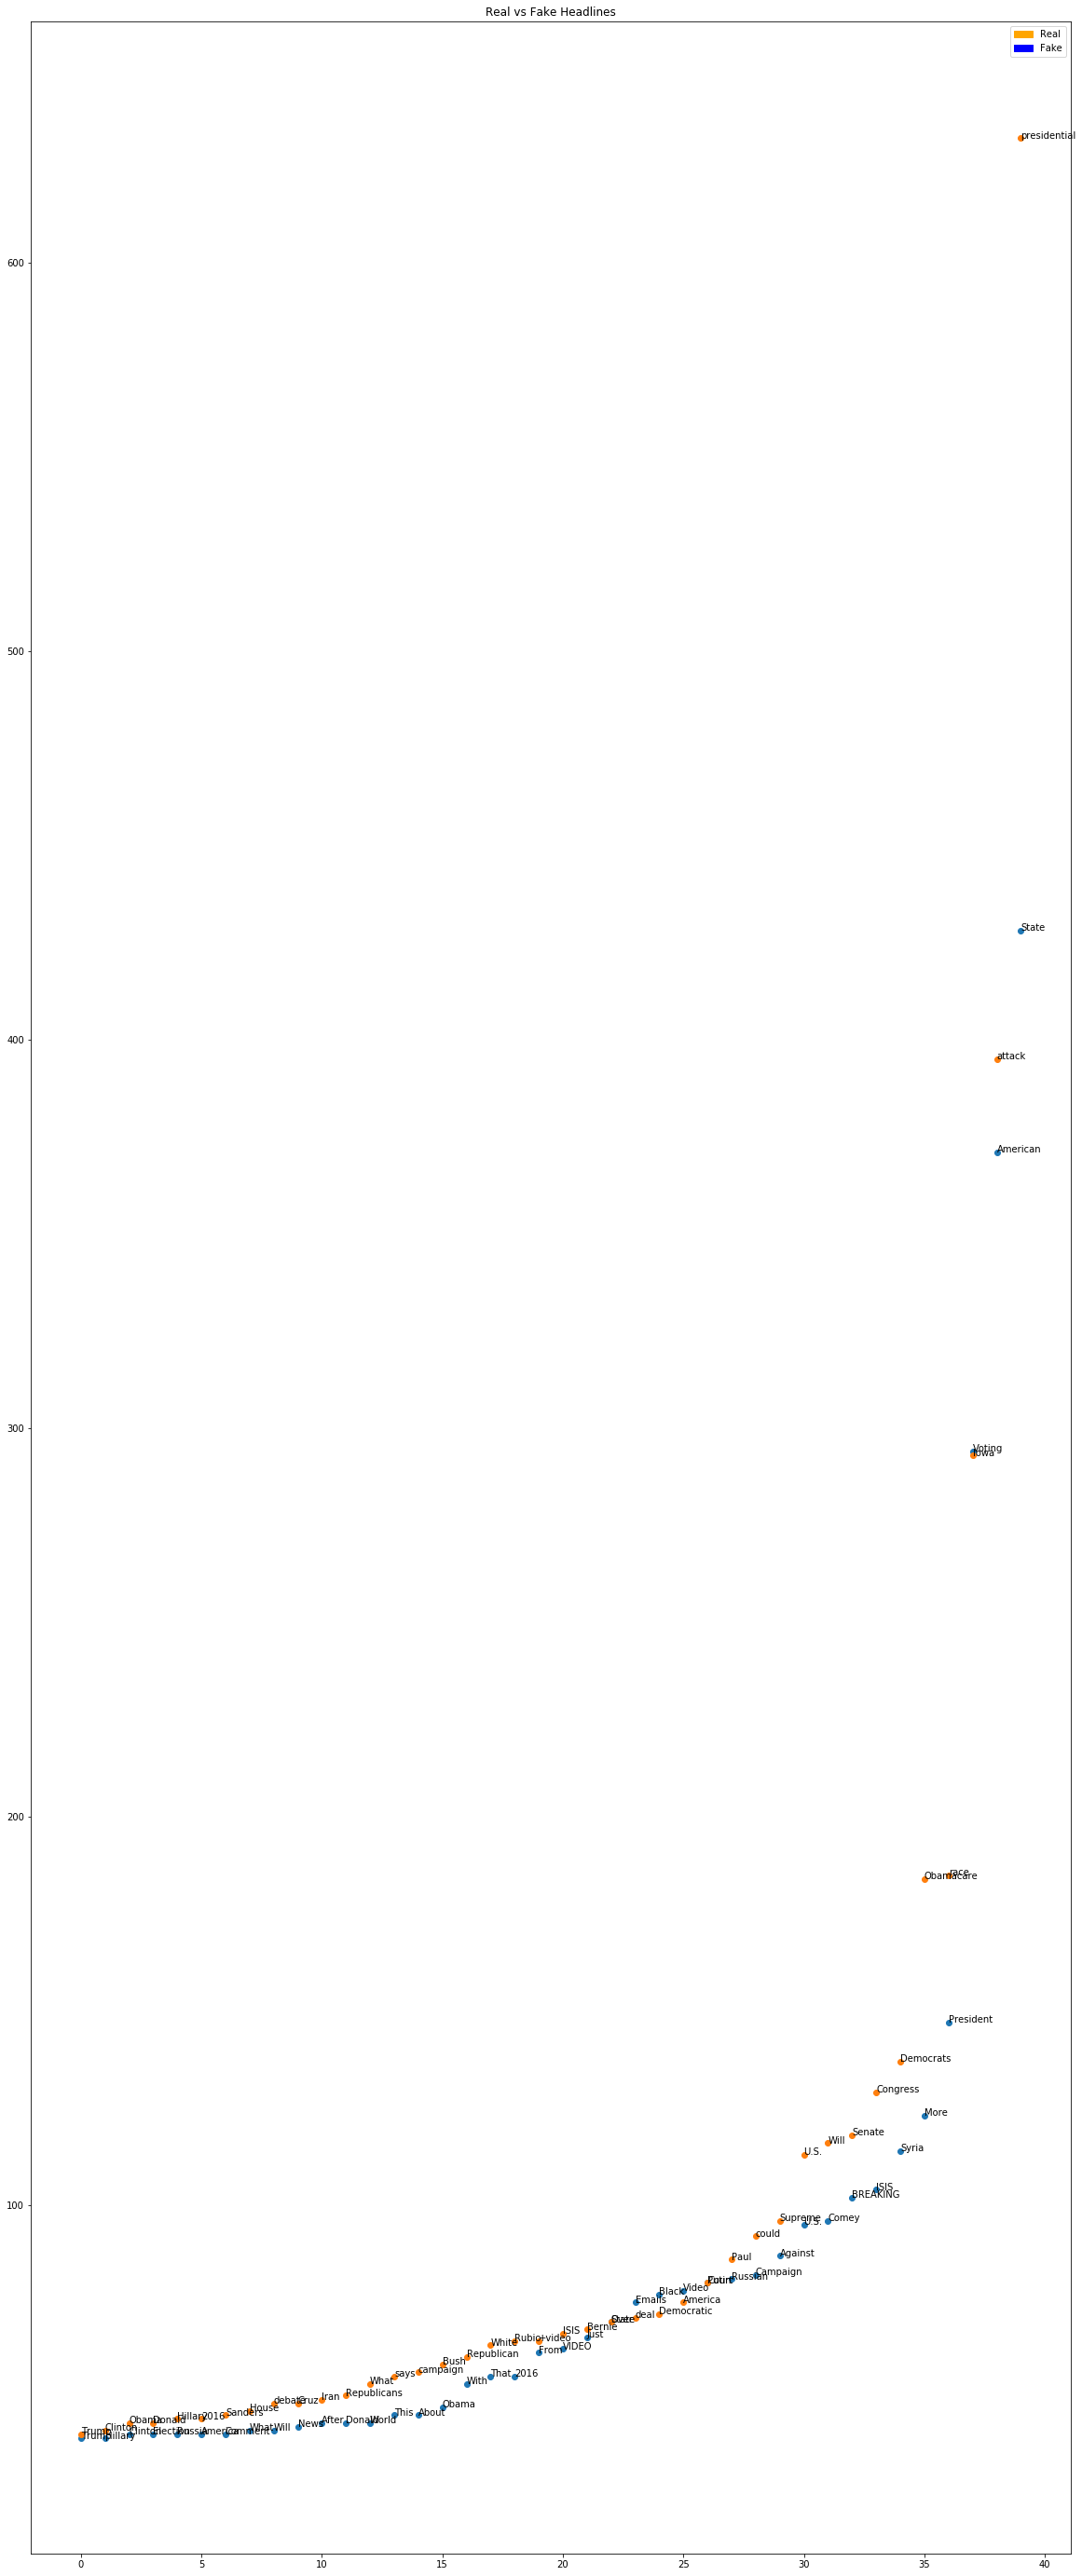

In [9]:
common_fake = nltk.FreqDist(fake_title_words).most_common(40)
common_real =nltk.FreqDist(real_title_words).most_common(40)
fake_ranks = []
fake_counts = []
real_ranks = []
real_counts = []

for ii, word in enumerate(reversed(common_fake)):
    fake_ranks.append(ii)
    fake_counts.append(word[1])

for ii, word in enumerate(reversed(common_real)):
    real_ranks.append(ii)
    real_counts.append(word[1])

plt.figure(figsize=(20, 50))

plt.scatter(fake_ranks, fake_counts)

for labels, fake_rank, fake_count in zip(common_fake, fake_ranks, fake_counts):
    plt.annotate(
        labels[0],
        xy = (fake_rank, fake_count)
    )

plt.scatter(real_ranks, real_counts)
plt.title('Real vs Fake Headlines')

for labels, real_rank, real_count in zip(common_real, real_ranks, real_counts):
    plt.annotate(
        labels[0],
        xy = (real_rank, real_count)
    )
    
real_patch = mpatches.Patch(color='orange', label='Real')
fake_patch = mpatches.Patch(color='blue', label='Fake')
plt.legend(handles=[real_patch, fake_patch])

plt.show()

In [10]:
def pad(x):
    
    if len(x) < 70:
        
        return x + ' ' * (70 - len(x))
    
    return x

def trim(x):
    
    if len(x) > 70:
        
        return x[:70]
    
    return x

data['title'] = data['title'].apply(pad)
data['title'] = data['title'].apply(trim)
data['title_length'] = [len(title) for title in data['title']]
data.describe()

,Unnamed: 0,label,title_length,text_length
count,6335.000000,6335.000000,6335.0,6335.000000
mean,5280.415627,0.500552,70.0,4707.250355
std,3038.503953,0.500039,0.0,5090.956446
min,2.000000,0.000000,70.0,1.000000
25%,2674.500000,0.000000,70.0,1741.500000
50%,5271.000000,1.000000,70.0,3642.000000
75%,7901.000000,1.000000,70.0,6192.000000
max,10557.000000,1.000000,70.0,115372.000000


In [11]:
text = ' '.join(data['title'])
dictionary_size = len(set(text))
dictionary = sorted(set(text))
character_map = { k:v for v, k in enumerate(dictionary) }
max_length = 70
batch_size = 50

In [12]:
def to_input(sentence, character_map, dictionary_size):
    
    sentence = np.array([character_map[char] for char in sentence])
    one_hot = np.zeros((len(sentence), dictionary_size))
    one_hot[np.arange(len(sentence)), sentence] = 1
    return one_hot

def batch(sentences, labels, start, batch_size):
    
    if start + batch_size < len(sentences):
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start: start + batch_size ]]
        labels = [label for label in labels[start: start + batch_size ]]
        start = start + batch_size
    
    else:
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start:]]
        labels = [label for label in labels[start:]]
        start = 0
    
    return np.array(inputs), np.array(labels) , start

def test_batch(sentences, labels):
    
        
    inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences]
    labels = [label for label in labels]

    return np.array(inputs), np.array(labels)

In [13]:
inputs = tf.placeholder(tf.float32, [None, max_length, dictionary_size])
labels = tf.placeholder(tf.int64, [None])
hidden_size = 512
cell = tf.contrib.rnn.LSTMCell(hidden_size, state_is_tuple = True)
initial_state = tf.contrib.rnn.LSTMStateTuple(tf.placeholder(tf.float32, [None, hidden_size], name = "c_init"), 
                                             tf.placeholder(tf.float32, [None, hidden_size], name = "h_init"))

with tf.variable_scope("softmax") as softmax:
    
    W_h = tf.get_variable("Wh", 
        shape = [hidden_size, 2], 
        dtype = tf.float32,
        initializer = tf.random_normal_initializer(.1,)
    )

    b_h = tf.get_variable("bh", 
        shape = 2,
        dtype = tf.float32,
        initializer = tf.ones_initializer()
    )

outputs, state = tf.nn.dynamic_rnn(cell, inputs, initial_state = initial_state)

logits = tf.matmul(outputs[:,-1, :], W_h) + b_h

loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = labels, logits = logits
    )
)

accuracy = tf.reduce_mean(
    tf.cast(tf.equal(
        tf.argmax(logits, 1),
        tf.cast(labels, tf.int64)
    ), 
    tf.float32)
)

optimizer = tf.train.AdamOptimizer(.001)

train_step = optimizer.minimize(loss)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [15]:
with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    initial = sess.run(cell.zero_state(50, tf.float32))

    start = 0
    inputs_, targets_, start = batch(data["title"][:5000], data["label"][:5000], start, batch_size)
    
    for step in range(1000):
        _, initial = sess.run([train_step, initial_state], feed_dict = {
            inputs:inputs_, 
            labels:targets_,
            initial_state:initial
        })
        
        inputs_, targets_, start = batch(data["title"][:5000], data["label"][:5000], start, batch_size)
        
            
        if step % 100 == 0:
            
            test_inputs, test_targets = test_batch(data["title"][5000:], data["label"][5000:])
            cost, acc = sess.run([loss, accuracy], feed_dict = {
            inputs:test_inputs, 
            labels:test_targets,
            initial_state:sess.run(cell.zero_state(len(data["label"][5000:]), tf.float32))
            })
            
            print(cost, acc)
            
            

1.7754345 0.54157305
0.6086433 0.6599251
0.49349174 0.7715356
0.48943684 0.76629215
0.4727494 0.78501874
0.5078251 0.76779026
0.47210848 0.7827715
0.47394767 0.77453184
0.48255312 0.788015
0.47720823 0.7827715


# TEXT